<a href="https://colab.research.google.com/github/wizard339/education/blob/main/qa_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers evaluate datasets

In [1]:
import os
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    )
import evaluate
from tqdm.auto import tqdm
import collections
import numpy as np

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [3]:
raw_datasets = load_dataset("sberquad")
print("Context: ", raw_datasets["train"][0]["context"])
print("Question: ", raw_datasets["train"][0]["question"])
print("Answer: ", raw_datasets["train"][0]["answers"])

Found cached dataset sberquad (C:/Users/Home/.cache/huggingface/datasets/sberquad/sberquad/1.0.0/62115d937acf2634cfacbfee10c13a7ee39df3ce345bb45af7088676f9811e77)


  0%|          | 0/3 [00:00<?, ?it/s]

Context:  В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине-зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито-углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий.
Question:  чем представлены органические остатки?
Answer:  {'text': ['известковыми выделениями сине-зелёных водорослей'], 'answer_start': [109]}


# Model ?

In [4]:
# MODEL_NAME = "DeepPavlov/rubert-base-cased"
MODEL_NAME = './/DeepPavlovrubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [5]:
stride=128
max_seq_length = 384

def preprocess_examples(examples):
    questions = [q.strip() for q in examples['question']]
    inputs = tokenizer(
        questions,
        examples['context'],
        max_length=max_seq_length,
        truncation='only_second',
        stride=stride,
        return_offsets_mapping=True,
        padding='max_length',
        )

    offset_mapping = inputs['offset_mapping']
    answers = examples['answers']
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer['answer_start'][0]
        end_char = answer['answer_start'][0] + len(answer['text'][0])
        sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context

        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)

        if offset[context_start][0] > end_char \
            or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:

      # Otherwise it's the start and end token positions

            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs['start_positions'] = start_positions
    inputs['end_positions'] = end_positions
    return inputs

In [8]:
DATASETS = DatasetDict({
    'train': raw_datasets["train"].map(
        preprocess_examples,
        batched=True).select(
            np.random.choice(range(len(raw_datasets["train"])), int(len(raw_datasets["train"])), replace=False)
        ),
    'validation': raw_datasets["validation"].map(
        preprocess_examples,
        batched=True),
    # .select(
    #         np.random.choice(range(len(raw_datasets["validation"])), int(len(raw_datasets["validation"])*0.3), replace=False)
    #     ),
    'test': raw_datasets["test"].map(
        preprocess_examples,
        batched=True)
        # .select(
        #     np.random.choice(range(len(raw_datasets["test"])), int(len(raw_datasets["test"])*0.3), replace=False)
        # )
})
DATASETS

Loading cached processed dataset at C:\Users\Home\.cache\huggingface\datasets\sberquad\sberquad\1.0.0\62115d937acf2634cfacbfee10c13a7ee39df3ce345bb45af7088676f9811e77\cache-7e93bb1453060460.arrow
Loading cached processed dataset at C:\Users\Home\.cache\huggingface\datasets\sberquad\sberquad\1.0.0\62115d937acf2634cfacbfee10c13a7ee39df3ce345bb45af7088676f9811e77\cache-de0abfa559edd956.arrow
Loading cached processed dataset at C:\Users\Home\.cache\huggingface\datasets\sberquad\sberquad\1.0.0\62115d937acf2634cfacbfee10c13a7ee39df3ce345bb45af7088676f9811e77\cache-83b4229ca7299d2b.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions'],
        num_rows: 45328
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions'],
        num_rows: 5036
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions'],
        num_rows: 23936
    })
})

In [9]:
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at .//DeepPavlovrubert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized fro

In [10]:
metric = evaluate.load("squad")

In [11]:
def compute_metrics(eval_preds):
    y_pred = np.argmax(eval_preds[0], -1).T

    f1_score = 0
    exact_match = 0
    for data, pred in zip(DATASETS['validation'], y_pred):
        # Convert answer start and end into characters positions in
        # original text using the offset mapping list
        start_char = data['offset_mapping'][pred[0]][0]
        end_char = data['offset_mapping'][pred[1]][1]
        # Create predictions and references dictionaries for metric function
        predictions = [{'prediction_text': data['context'][start_char:end_char],
                        'id': str(data['id'])}]
        references = [{'answers': data['answers'],
                       'id': str(data['id'])}]
        results = metric.compute(predictions=predictions,
                                 references=references)
        # Add metric to running sum variable to calculate average after,
        # change outputs from 0-100 range to 0-1 range
        f1_score += results['f1'] / 100
        exact_match += results['exact_match'] / 100
    # Calculate the average
    f1_score /= len(DATASETS['validation'])
    exact_match /= len(DATASETS['validation'])
    return {'f1': f1_score, 'exact_match': exact_match}

In [12]:
LR = 2e-5
STEPS_NUMBER = 200  # for logging and saving
EPOCHS_NUM = 2
BATCH_SIZE = 16

In [13]:
training_args = TrainingArguments("test-trainer",
                                  evaluation_strategy="steps",
                                  eval_steps=STEPS_NUMBER,
                                  logging_steps=STEPS_NUMBER,
                                  save_steps=STEPS_NUMBER,
                                  optim="adamw_torch",
                                  learning_rate=LR,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  warmup_steps=150,
                                  num_train_epochs=EPOCHS_NUM,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='eval_f1')

trainer = Trainer(model,
                  training_args,
                  train_dataset=DATASETS['train'],
                  eval_dataset=DATASETS['validation'],
                  compute_metrics=compute_metrics)

In [14]:
torch.cuda.empty_cache()
os.environ["WANDB_DISABLED"] = "true"
# transformers.logging.set_verbosity('CRITICAL')

trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, context, id, question, title, answers. If offset_mapping, context, id, question, title, answers are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 45328
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5666
  Number of trainable parameters = 177264386


Step,Training Loss,Validation Loss,F1,Exact Match
200,4.126500,2.466181,0.627418,0.436060
400,2.350200,2.100603,0.721188,0.522637
600,2.161600,1.887294,0.763472,0.559968
800,1.989600,1.822898,0.771486,0.570095
1000,1.873900,1.774205,0.780726,0.578038
1200,1.829100,1.746154,0.798388,0.601072
1400,1.825000,1.702170,0.765160,0.558181
1600,1.802000,1.659087,0.806170,0.611199
1800,1.753300,1.657937,0.791002,0.591739
2000,1.703000,1.620858,0.802134,0.605838


The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, context, id, question, title, answers. If offset_mapping, context, id, question, title, answers are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5036
  Batch size = 16
Saving model checkpoint to test-trainer\checkpoint-200
Configuration saved in test-trainer\checkpoint-200\config.json
Model weights saved in test-trainer\checkpoint-200\pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, context, id, question, title, answers. If offset_mapping, context, id, question, title, answers are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 50

TrainOutput(global_step=5666, training_loss=1.7012138851447194, metrics={'train_runtime': 6676.0023, 'train_samples_per_second': 13.579, 'train_steps_per_second': 0.849, 'total_flos': 1.7766089083994112e+16, 'train_loss': 1.7012138851447194, 'epoch': 2.0})

In [15]:
predictions, _, _ = trainer.predict(DATASETS['test'])

The following columns in the test set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, context, id, question, title, answers. If offset_mapping, context, id, question, title, answers are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 23936
  Batch size = 16


In [19]:
preds = trainer.predict(DATASETS['test'])

The following columns in the test set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, context, id, question, title, answers. If offset_mapping, context, id, question, title, answers are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 23936
  Batch size = 16


In [23]:
start_logits, end_logits = predictions

In [17]:
def compute_metrics_test(eval_preds):
    y_pred = np.argmax(eval_preds[0], -1).T

    f1_score = 0
    exact_match = 0
    for data, pred in zip(DATASETS['test'], y_pred):
        # Convert answer start and end into characters positions in
        # original text using the offset mapping list
        start_char = data['offset_mapping'][pred[0]][0]
        end_char = data['offset_mapping'][pred[1]][1]
        # Create predictions and references dictionaries for metric function
        predictions = [{'prediction_text': data['context'][start_char:end_char],
                        'id': str(data['id'])}]
        references = [{'answers': data['answers'],
                       'id': str(data['id'])}]
        results = metric.compute(predictions=predictions,
                                 references=references)
        # Add metric to running sum variable to calculate average after,
        # change outputs from 0-100 range to 0-1 range
        f1_score += results['f1'] / 100
        exact_match += results['exact_match'] / 100
    # Calculate the average
    f1_score /= len(DATASETS['test'])
    exact_match /= len(DATASETS['test'])
    return {'f1': f1_score, 'exact_match': exact_match}

In [29]:
DATASETS['test']

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions'],
    num_rows: 23936
})

In [24]:
ct = DATASETS['test']['context'][0]
ct

'Многоклеточный организм — внесистематическая категория живых организмов, тело которых состоит из многих клеток, большая часть которых (кроме стволовых, например, клеток камбия у растений) дифференцированы, то есть различаются по строению и выполняемым функциям. Следует отличать многоклеточность и колониальность. У колониальных организмов отсутствуют настоящие дифференцированные клетки, а следовательно, и разделение тела на ткани. Граница между многоклеточностью и колониальностью нечёткая. Например, вольвокс часто относят к колониальным организмам, хотя в его колониях есть чёткое деление клеток на генеративные и соматические. Кроме дифференциации клеток, для многоклеточных характерен и более высокий уровень интеграции, чем для колониальных форм. Многоклеточные животные, возможно, появились на Земле 2,1 миллиарда лет назад, вскоре после кислородной революции .'

In [26]:
que = DATASETS['test']['question'][0]
que

'У каких организмов отсутствуют настоящие дифференцированные клетки?'

In [33]:
ans = DATASETS['test']['answers'][1000]
ans

{'text': [''], 'answer_start': [-1]}

In [20]:
compute_metrics_test(preds)

{'f1': 0.0, 'exact_match': 0.015040106951871657}

In [26]:
def compute_metrics_test(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": str(example_id), "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": str(example_id), "prediction_text": ""})

    theoretical_answers = [{"id": str(ex["id"]), "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [27]:
compute_metrics_test(start_logits, end_logits, DATASETS['test'], raw_datasets["test"])

KeyError: 'example_id'

# Model 1: fine-tuning 'DeepPavlov/rubert-base-cased'

In [4]:
model_checkpoint = 'DeepPavlov/rubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [5]:
context = raw_datasets["train"][0]["context"]
question = raw_datasets["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'[CLS] чем представлены органические остатки? [SEP] В протерозойских отложениях органические остатки встречаются намного чаще, чем в архейских. Они представлены известковыми выделениями сине - зелёных водорослей, ходами червей, остатками кишечнополостных. Кроме известковых водорослей, к числу древнейших растительных остатков относятся скопления графито - углистого вещества, образовавшегося в результате разложения Corycium enigmaticum. В кремнистых сланцах железорудной формации Канады найдены нитевидные водоросли, грибные нити и формы, близкие современным кокколитофоридам. В железистых кварцитах Северной Америки и Сибири обнаружены железистые продукты жизнедеятельности бактерий. [SEP]'

Как в данном случае можно сформировать метки классов? Обычно поступают так: для каждого токена мы имеем два бинарных класса (является данный токен началом ответа или его окончанием). Выглядит это следующим образом:


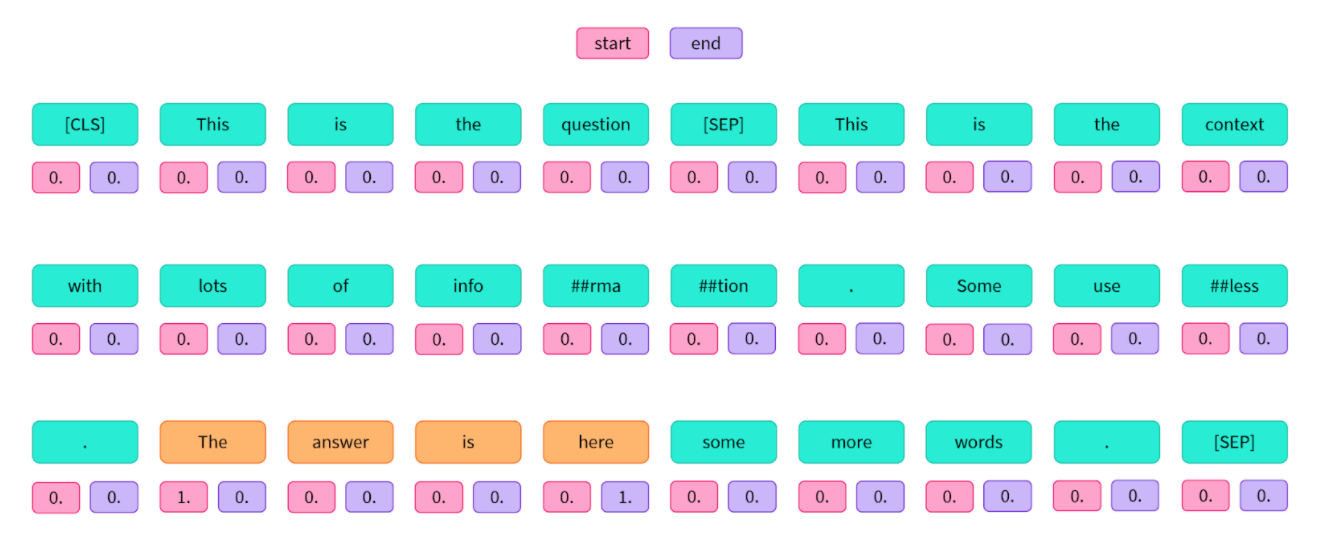

In [6]:
max_length = 384
stride = 128

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples['question']]
    inputs = tokenizer(
        questions,
        examples['context'],
        max_length=max_length,
        truncation='only_second',
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding='max_length',
        )

    offset_mapping = inputs.pop('offset_mapping')
    sample_map = inputs.pop('overflow_to_sample_mapping')
    answers = examples['answers']
    start_positions = []
    end_positions = []

    for (i, offset) in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        # answer = answers[i]
        start_char = answer['answer_start'][0]
        end_char = answer['answer_start'][0] + len(answer['text'][0])
        sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context

        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)

        if offset[context_start][0] > start_char \
            or offset[context_end][1] < end_char:
        # if offset[context_start][0] > end_char \
        # or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:

      # Otherwise it's the start and end token positions

            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs['start_positions'] = start_positions
    inputs['end_positions'] = end_positions
    return inputs

In [7]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples['question']]
    inputs = tokenizer(
        questions,
        examples['context'],
        max_length=max_length,
        truncation='only_second',
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding='max_length',
        )

    sample_map = inputs.pop('overflow_to_sample_mapping')
    example_ids = []

    for i in range(len(inputs['input_ids'])):
        sample_idx = sample_map[i]
        example_ids.append(examples['id'][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs['offset_mapping'][i]
        inputs['offset_mapping'][i] = [(o if sequence_ids[k]
                == 1 else None) for (k, o) in enumerate(offset)]

    inputs['example_id'] = example_ids
    return inputs

In [8]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

print(f'Train before preprocessing: {len(raw_datasets["train"])}, after: {len(train_dataset)}')
print(f'Validation before preprocessing: {len(raw_datasets["validation"])}, after: {len(validation_dataset)}')

Map:   0%|          | 0/45328 [00:00<?, ? examples/s]

Map:   0%|          | 0/5036 [00:00<?, ? examples/s]

Train before preprocessing: 45328, after: 45544
Validation before preprocessing: 5036, after: 5063


## Post-processing

In [11]:
metric = evaluate.load("squad")

In [29]:
n_best = 20
max_answer_length = 30

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": str(example_id), "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": str(example_id), "prediction_text": ""})

    theoretical_answers = [{"id": str(ex["id"]), "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [13]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from 

In [14]:
args = TrainingArguments(
    "DeepPavlov/rubert-base-cased",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
)

In [15]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)

trainer.train()

Using cuda_amp half precision backend
C:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 45544
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17079
  Number of trainable parameters = 177264386
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,2.672100
1000,2.027800
1500,1.897700
2000,1.771800
2500,1.687400
3000,1.674000
3500,1.638200
4000,1.617100
4500,1.598100
5000,1.591900


Saving model checkpoint to DeepPavlov/rubert-base-cased\checkpoint-5693
Configuration saved in DeepPavlov/rubert-base-cased\checkpoint-5693\config.json
Model weights saved in DeepPavlov/rubert-base-cased\checkpoint-5693\pytorch_model.bin
tokenizer config file saved in DeepPavlov/rubert-base-cased\checkpoint-5693\tokenizer_config.json
Special tokens file saved in DeepPavlov/rubert-base-cased\checkpoint-5693\special_tokens_map.json
Saving model checkpoint to DeepPavlov/rubert-base-cased\checkpoint-11386
Configuration saved in DeepPavlov/rubert-base-cased\checkpoint-11386\config.json
Model weights saved in DeepPavlov/rubert-base-cased\checkpoint-11386\pytorch_model.bin
tokenizer config file saved in DeepPavlov/rubert-base-cased\checkpoint-11386\tokenizer_config.json
Special tokens file saved in DeepPavlov/rubert-base-cased\checkpoint-11386\special_tokens_map.json
Saving model checkpoint to DeepPavlov/rubert-base-cased\checkpoint-17079
Configuration saved in DeepPavlov/rubert-base-cased\ch

TrainOutput(global_step=17079, training_loss=1.3047743794566136, metrics={'train_runtime': 4072.8447, 'train_samples_per_second': 33.547, 'train_steps_per_second': 4.193, 'total_flos': 2.6776123849764864e+16, 'train_loss': 1.3047743794566136, 'epoch': 3.0})

In [17]:
predictions, _, _ = trainer.predict(validation_dataset)

The following columns in the test set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 5063
  Batch size = 8


In [22]:
start_logits, end_logits = predictions

In [30]:
compute_metrics(start_logits, end_logits, validation_dataset, raw_datasets["validation"])

  0%|          | 0/5036 [00:00<?, ?it/s]

{'exact_match': 57.267672756155676, 'f1': 77.41556164785062}